In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import time

In [40]:
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, average_precision_score
)

In [41]:
import xgboost as xgb
import lightgbm as lgb


In [42]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


In [43]:
import shap


In [44]:
!pip install -q  mlflow


In [45]:
import mlflow
import mlflow.sklearn

In [46]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()


In [47]:
with open('selected_features.pkl', 'rb') as f:
    selected_features = pickle.load(f)

print(f" Train set: {X_train.shape[0]} samples × {X_train.shape[1]} features")
print(f" Test set: {X_test.shape[0]} samples × {X_test.shape[1]} features")
print(f"\n Distribution Train: {np.bincount(y_train)}")
print(f" Distribution Test: {np.bincount(y_test)}")


 Train set: 900 samples × 58 features
 Test set: 225 samples × 58 features

 Distribution Train: [720 180]
 Distribution Test: [180  45]


In [48]:
class_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"\n Ratio de déséquilibre: {class_ratio:.2f}:1")



 Ratio de déséquilibre: 4.00:1


Entraînement et évaluation

In [49]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Entraîne et évalue un modèle"""

    start_time = time.time()

    # Entraînement
    model.fit(X_train, y_train)

    training_time = time.time() - start_time

    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Métriques
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'PR-AUC': average_precision_score(y_test, y_pred_proba),
        'Training Time (s)': training_time
    }

    return metrics, model, y_pred, y_pred_proba


In [66]:
models_fixed = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=5000,
        solver='saga',
        random_state=42
    ),

    'Random Forest': RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),

    'XGBoost': xgb.XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.05,
        scale_pos_weight=class_ratio,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc'

    ),

    'LightGBM': lgb.LGBMClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.05,
        num_leaves=50,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )
}


In [67]:
results_fixed = []
trained_models_fixed = {}
predictions_fixed = {}


In [68]:
print(" entraînement avec paramètres optimisés...\n")

for name, model in models_fixed.items():
    print(f" Training: {name}...")

    metrics, trained_model, y_pred, y_pred_proba = evaluate_model(
        model, X_train, X_test, y_train, y_test, name
    )

    results_fixed.append(metrics)
    trained_models_fixed[name] = trained_model
    predictions_fixed[name] = {'y_pred': y_pred, 'y_proba': y_pred_proba}

    print(f"    ROC-AUC: {metrics['ROC-AUC']:.4f} | F1: {metrics['F1-Score']:.4f}")

results_fixed_df = pd.DataFrame(results_fixed).sort_values('ROC-AUC', ascending=False)
print("\n RÉSULTATS AMÉLIORÉS:")
print(results_fixed_df.round(4).to_string(index=False))

 entraînement avec paramètres optimisés...

 Training: Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    ROC-AUC: 0.6637 | F1: 0.3711
 Training: Random Forest...
    ROC-AUC: 0.6653 | F1: 0.2143
 Training: XGBoost...
    ROC-AUC: 0.6475 | F1: 0.2703
 Training: LightGBM...
    ROC-AUC: 0.6246 | F1: 0.2051

 RÉSULTATS AMÉLIORÉS:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC  Training Time (s)
      Random Forest    0.8044     0.5455  0.1333    0.2143   0.6653  0.3521             1.2171
Logistic Regression    0.4578     0.2416  0.8000    0.3711   0.6637  0.3200             4.7075
            XGBoost    0.7600     0.3448  0.2222    0.2703   0.6475  0.3092             6.3523
           LightGBM    0.7244     0.2424  0.1778    0.2051   0.6246  0.2855             0.5278


In [64]:
results_fixed_df.iloc[0]['Model']

'Random Forest'

🎯 Seuil optimal: 0.16
🎯 F1-Score avec seuil optimal: 0.3966


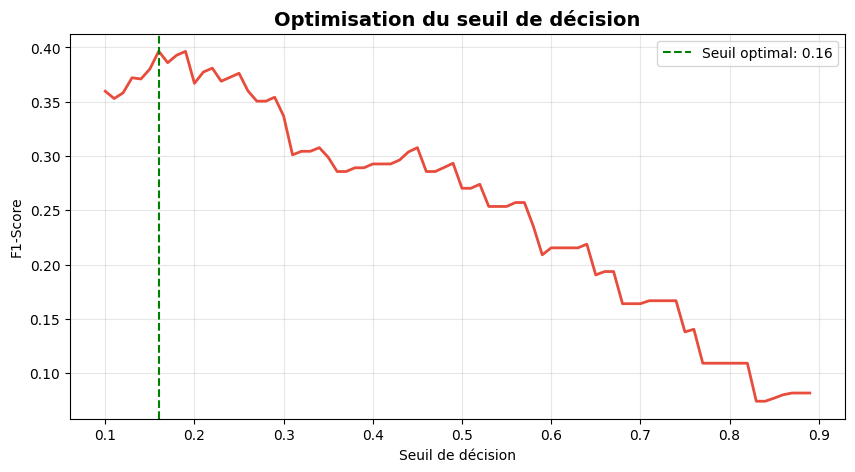


📊 Performance avec seuil optimal (0.16):
   Precision: 0.3239
   Recall: 0.5111
   F1-Score: 0.3966


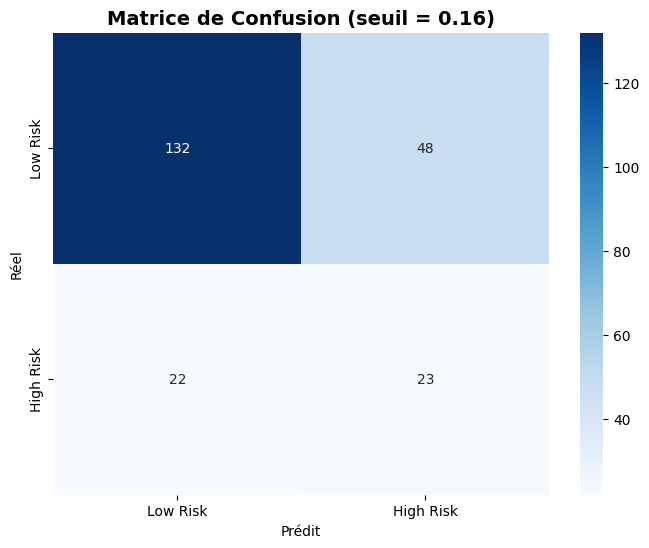

In [70]:
# %%
# Trouver le seuil optimal pour maximiser le F1-Score
from sklearn.metrics import f1_score

best_model_name = "XGBoost"
y_proba_best = predictions_fixed[best_model_name]['y_proba']

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_proba_best >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

optimal_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"🎯 Seuil optimal: {optimal_threshold:.2f}")
print(f"🎯 F1-Score avec seuil optimal: {best_f1:.4f}")

# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, color='#e74c3c', linewidth=2)
plt.axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Seuil optimal: {optimal_threshold:.2f}')
plt.xlabel('Seuil de décision')
plt.ylabel('F1-Score')
plt.title('Optimisation du seuil de décision', fontsize=14, weight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# %%
# Appliquer le seuil optimal
y_pred_optimal = (y_proba_best >= optimal_threshold).astype(int)

print(f"\n📊 Performance avec seuil optimal ({optimal_threshold:.2f}):")
print(f"   Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_optimal):.4f}")

# Matrice de confusion avec seuil optimal
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title(f'Matrice de Confusion (seuil = {optimal_threshold:.2f})', fontsize=14, weight='bold')
plt.ylabel('Réel')
plt.xlabel('Prédit')
plt.show()

In [54]:
results_df = pd.DataFrame(results_fixed).sort_values('ROC-AUC', ascending=False)
results_df = results_df.round(4)

print("\n📊 COMPARAISON DES MODÈLES:")
print(results_df.to_string(index=False))



📊 COMPARAISON DES MODÈLES:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC  Training Time (s)
      Random Forest    0.8044     0.5455  0.1333    0.2143   0.6653  0.3521             3.7419
Logistic Regression    0.4578     0.2416  0.8000    0.3711   0.6637  0.3200            12.7797
            XGBoost    0.7556     0.3333  0.2222    0.2667   0.6623  0.3042             7.5220
           LightGBM    0.7244     0.2424  0.1778    0.2051   0.6246  0.2855             1.3559


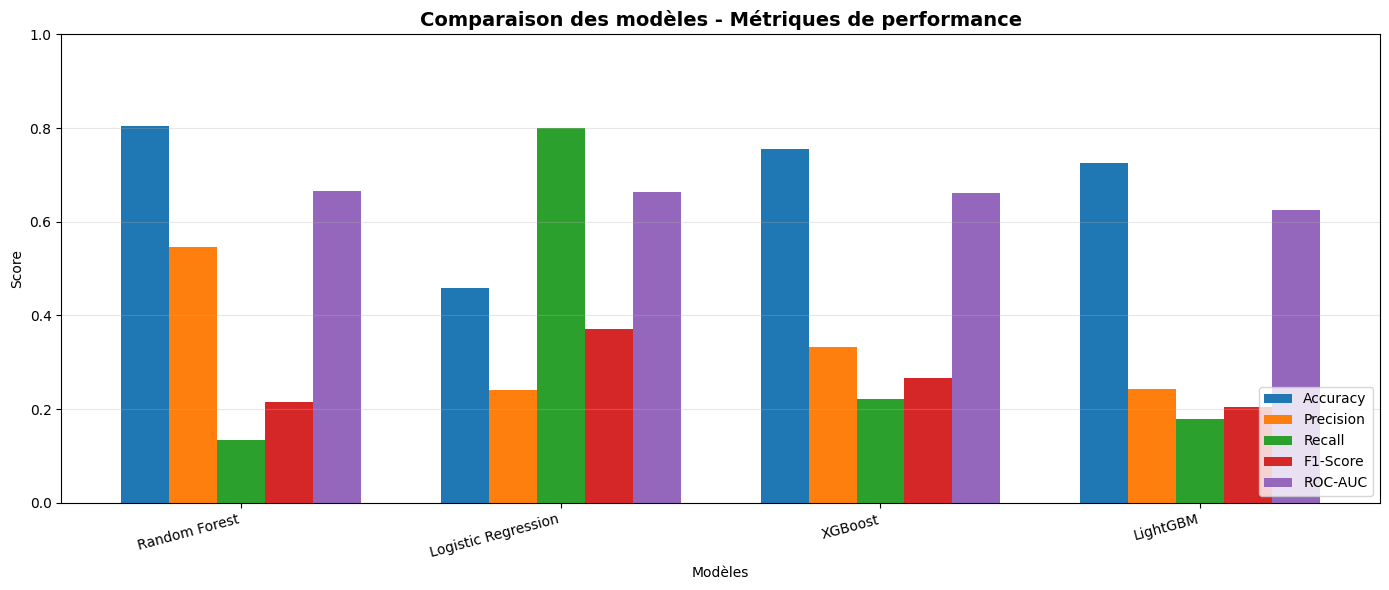

In [69]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    bars = ax.bar(x + i * width, results_df[metric], width, label=metric)

ax.set_xlabel('Modèles')
ax.set_ylabel('Score')
ax.set_title('Comparaison des modèles - Métriques de performance', fontsize=14, weight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(results_df['Model'], rotation=15, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

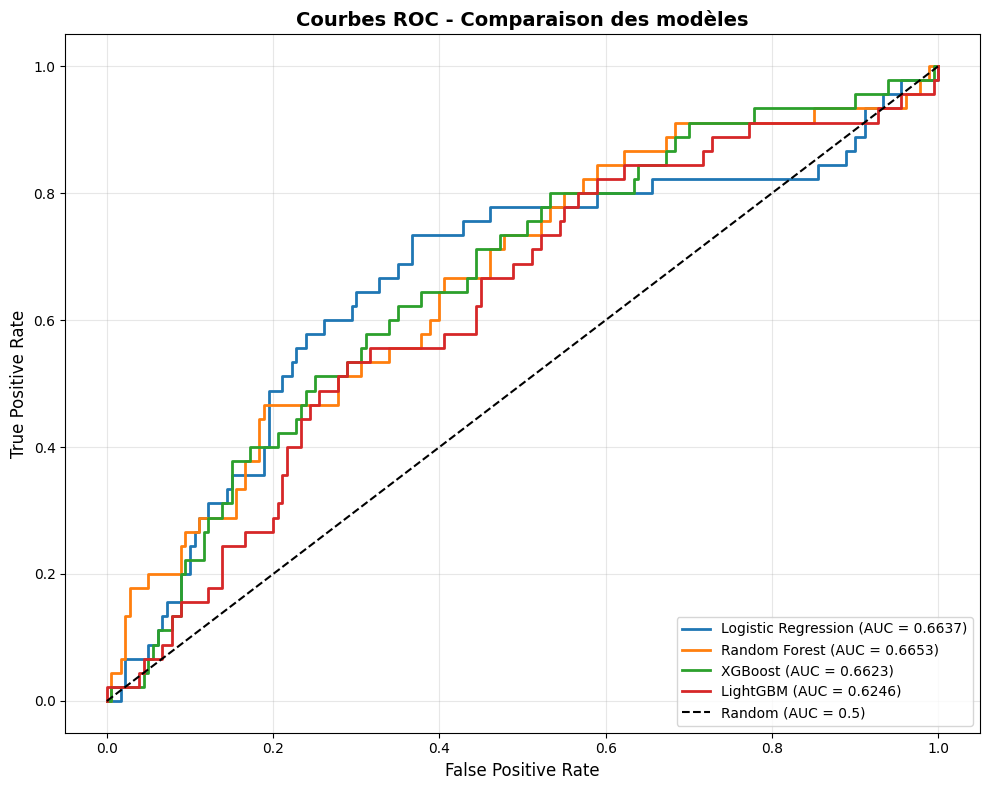

In [56]:
plt.figure(figsize=(10, 8))

for name, preds in predictions_fixed.items():
    fpr, tpr, _ = roc_curve(y_test, preds['y_proba'])
    auc = roc_auc_score(y_test, preds['y_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Courbes ROC - Comparaison des modèles', fontsize=14, weight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


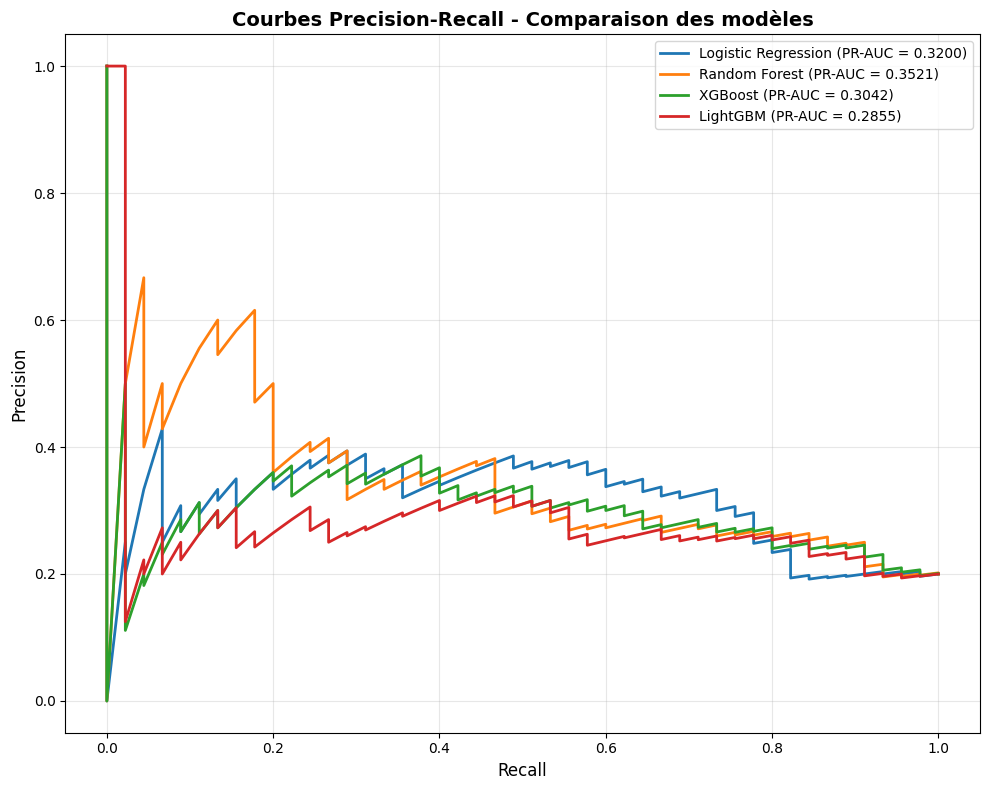

In [57]:
plt.figure(figsize=(10, 8))

for name, preds in predictions_fixed.items():
    precision, recall, _ = precision_recall_curve(y_test, preds['y_proba'])
    pr_auc = average_precision_score(y_test, preds['y_proba'])
    plt.plot(recall, precision, label=f'{name} (PR-AUC = {pr_auc:.4f})', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Courbes Precision-Recall - Comparaison des modèles', fontsize=14, weight='bold')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [58]:
best_model_name = results_fixed_df.iloc[0]['Model']
best_model = models_fixed[best_model_name]
best_preds = predictions_fixed[best_model_name]

In [59]:
print(f" Meilleur modèle: {best_model_name}")
print(f"   ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f}")
print(f"   F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")


 Meilleur modèle: Random Forest
   ROC-AUC: 0.6653
   F1-Score: 0.2143


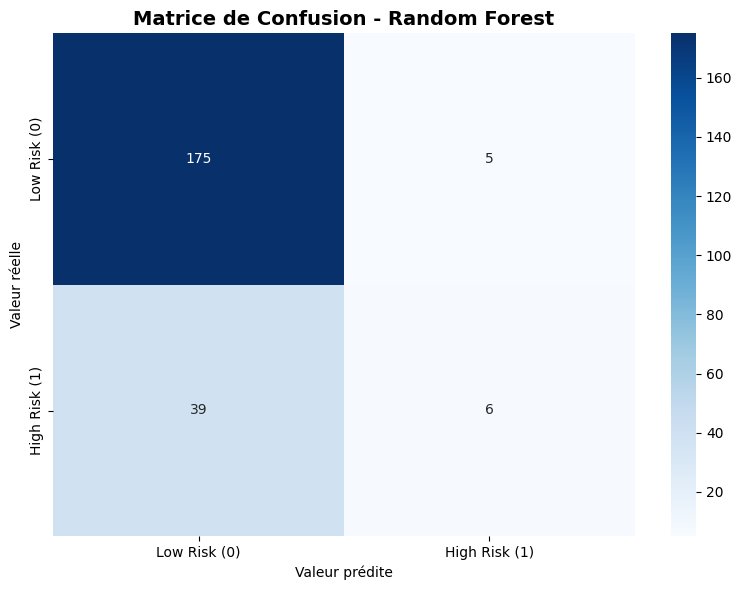

In [60]:
cm = confusion_matrix(y_test, best_preds['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk (0)', 'High Risk (1)'],
            yticklabels=['Low Risk (0)', 'High Risk (1)'])
plt.title(f'Matrice de Confusion - {best_model_name}', fontsize=14, weight='bold')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.tight_layout()
plt.show()

In [61]:
print(f"\n Rapport de classification - {best_model_name}:")
print(classification_report(y_test, best_preds['y_pred'],
                          target_names=['Low Risk', 'High Risk']))



 Rapport de classification - Random Forest:
              precision    recall  f1-score   support

    Low Risk       0.82      0.97      0.89       180
   High Risk       0.55      0.13      0.21        45

    accuracy                           0.80       225
   macro avg       0.68      0.55      0.55       225
weighted avg       0.76      0.80      0.75       225



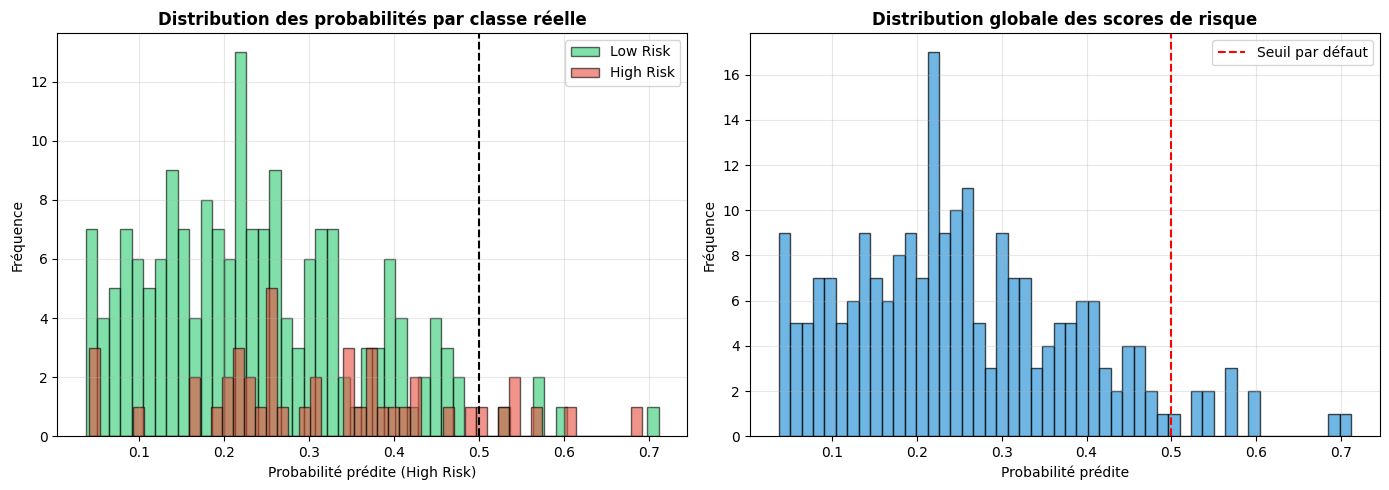

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Par classe réelle
for label, color, name in [(0, '#2ecc71', 'Low Risk'), (1, '#e74c3c', 'High Risk')]:
    mask = y_test == label
    axes[0].hist(best_preds['y_proba'][mask], bins=50, alpha=0.6,
                 color=color, label=name, edgecolor='black')

axes[0].set_xlabel('Probabilité prédite (High Risk)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des probabilités par classe réelle', fontsize=12, weight='bold')
axes[0].legend()
axes[0].axvline(x=0.5, color='black', linestyle='--', label='Seuil 0.5')
axes[0].grid(alpha=0.3)

# Calibration plot simplifié
axes[1].hist(best_preds['y_proba'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Probabilité prédite')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution globale des scores de risque', fontsize=12, weight='bold')
axes[1].axvline(x=0.5, color='red', linestyle='--', label='Seuil par défaut')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Amélioration de F1 score

In [71]:
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

best_model = trained_models_fixed['XGBoost']
y_proba = best_model.predict_proba(X_test)[:, 1]

In [72]:
thresholds = np.arange(0.05, 0.95, 0.01)
results_threshold = []

In [73]:
for thresh in thresholds:
    y_pred_t = (y_proba >= thresh).astype(int)
    results_threshold.append({
        'threshold': thresh,
        'f1': f1_score(y_test, y_pred_t),
        'precision': precision_score(y_test, y_pred_t, zero_division=0),
        'recall': recall_score(y_test, y_pred_t)
    })

In [74]:
thresh_df = pd.DataFrame(results_threshold)
optimal_idx = thresh_df['f1'].idxmax()
optimal_threshold = thresh_df.loc[optimal_idx, 'threshold']

In [75]:
print(f" Seuil optimal: {optimal_threshold:.2f}")
print(f"   F1-Score: {thresh_df.loc[optimal_idx, 'f1']:.4f}")
print(f"   Precision: {thresh_df.loc[optimal_idx, 'precision']:.4f}")
print(f"   Recall: {thresh_df.loc[optimal_idx, 'recall']:.4f}")


 Seuil optimal: 0.08
   F1-Score: 0.4052
   Precision: 0.2870
   Recall: 0.6889


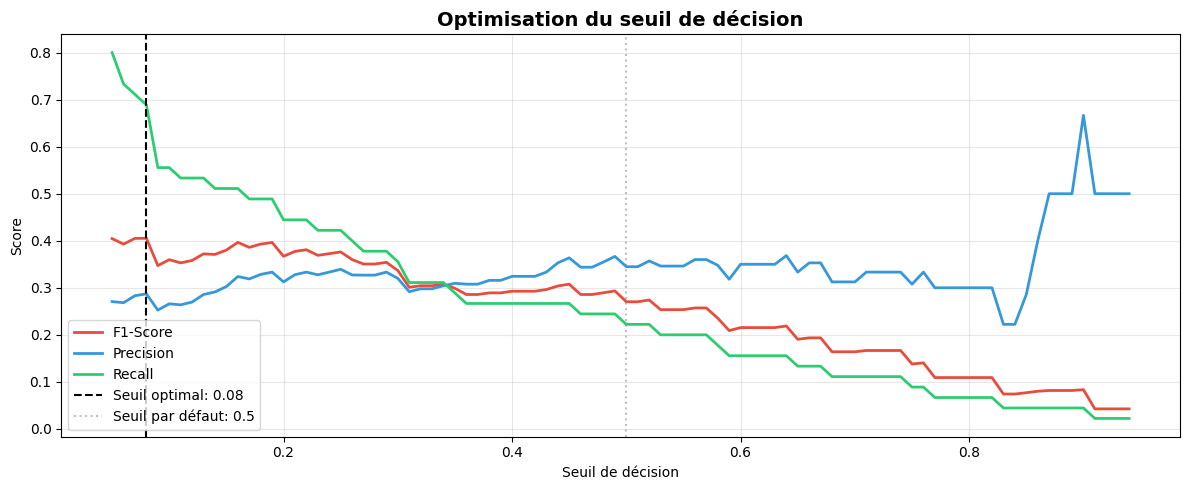

In [76]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(thresh_df['threshold'], thresh_df['f1'], label='F1-Score', linewidth=2, color='#e74c3c')
ax.plot(thresh_df['threshold'], thresh_df['precision'], label='Precision', linewidth=2, color='#3498db')
ax.plot(thresh_df['threshold'], thresh_df['recall'], label='Recall', linewidth=2, color='#2ecc71')
ax.axvline(x=optimal_threshold, color='black', linestyle='--', label=f'Seuil optimal: {optimal_threshold:.2f}')
ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, label='Seuil par défaut: 0.5')
ax.set_xlabel('Seuil de décision')
ax.set_ylabel('Score')
ax.set_title('Optimisation du seuil de décision', fontsize=14, weight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)


In [78]:
print(f"\n Comparaison seuil 0.5 vs seuil optimal ({optimal_threshold:.2f}):")
print(f"\n{'Métrique':<15} {'Seuil 0.5':<12} {'Seuil Optimal':<12} {'Amélioration':<12}")
print("-" * 55)


 Comparaison seuil 0.5 vs seuil optimal (0.08):

Métrique        Seuil 0.5    Seuil Optimal Amélioration
-------------------------------------------------------


In [79]:
y_pred_default = (y_proba >= 0.5).astype(int)
for metric_name, metric_func in [('F1-Score', f1_score), ('Precision', precision_score), ('Recall', recall_score)]:
    score_default = metric_func(y_test, y_pred_default)
    score_optimal = metric_func(y_test, y_pred_optimal)
    improvement = ((score_optimal - score_default) / score_default) * 100 if score_default > 0 else 0
    print(f"{metric_name:<15} {score_default:<12.4f} {score_optimal:<12.4f} {improvement:+.1f}%")


F1-Score        0.2703       0.4052       +49.9%
Precision       0.3448       0.2870       -16.8%
Recall          0.2222       0.6889       +210.0%


In [80]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN


In [81]:


smote = SMOTE(random_state=42, sampling_strategy=0.5)  # 50% de la classe majoritaire
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Avant SMOTE: {np.bincount(y_train)}")
print(f"Après SMOTE: {np.bincount(y_train_smote)}")

Avant SMOTE: [720 180]
Après SMOTE: [720 360]


In [101]:
lgb_smote = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=50,
    random_state=42,
    verbose=-1
)

In [102]:
lgb_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = lgb_smote.predict(X_test)
y_proba_smote = lgb_smote.predict_proba(X_test)[:, 1]


In [103]:
print(f"\n Résultats avec SMOTE:")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_proba_smote):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_smote):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_smote):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_smote):.4f}")



 Résultats avec SMOTE:
   ROC-AUC: 0.6074
   F1-Score: 0.2703
   Precision: 0.3448
   Recall: 0.2222


In [104]:
results_smote_thresh = []

for thresh in thresholds:
    y_pred_t = (y_proba_smote >= thresh).astype(int)
    results_smote_thresh.append({
        'threshold': thresh,
        'f1': f1_score(y_test, y_pred_t),
        'precision': precision_score(y_test, y_pred_t, zero_division=0),
        'recall': recall_score(y_test, y_pred_t)
    })

In [105]:
thresh_smote_df = pd.DataFrame(results_smote_thresh)
optimal_smote_idx = thresh_smote_df['f1'].idxmax()
optimal_smote_threshold = thresh_smote_df.loc[optimal_smote_idx, 'threshold']

y_pred_smote_optimal = (y_proba_smote >= optimal_smote_threshold).astype(int)


In [106]:
print(f" SMOTE + Seuil optimal ({optimal_smote_threshold:.2f}):")
print(f"   F1-Score: {f1_score(y_test, y_pred_smote_optimal):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_smote_optimal):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_smote_optimal):.4f}")


 SMOTE + Seuil optimal (0.05):
   F1-Score: 0.3660
   Precision: 0.2593
   Recall: 0.6222


In [107]:
weight_ratios = [5, 10, 15, 20, 30]
results_weights = []

In [108]:
for weight in weight_ratios:
    lgb_weighted = lgb.LGBMClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.05,
        class_weight={0: 1, 1: weight},  # Poids élevé pour High Risk
        random_state=42,
        verbose=-1
    )
    lgb_weighted.fit(X_train, y_train)
    y_pred_w = lgb_weighted.predict(X_test)
    y_proba_w = lgb_weighted.predict_proba(X_test)[:, 1]

    results_weights.append({
        'weight': f'1:{weight}',
        'f1': f1_score(y_test, y_pred_w),
        'precision': precision_score(y_test, y_pred_w),
        'recall': recall_score(y_test, y_pred_w),
        'roc_auc': roc_auc_score(y_test, y_proba_w)
    })


In [109]:
weights_df = pd.DataFrame(results_weights)
print("\n Impact du class_weight:")
print(weights_df.round(4).to_string(index=False))



 Impact du class_weight:
weight     f1  precision  recall  roc_auc
   1:5 0.2278     0.2647  0.2000   0.6379
  1:10 0.3059     0.3250  0.2889   0.6343
  1:15 0.2889     0.2889  0.2889   0.6348
  1:20 0.3579     0.3400  0.3778   0.6132
  1:30 0.3469     0.3208  0.3778   0.6314


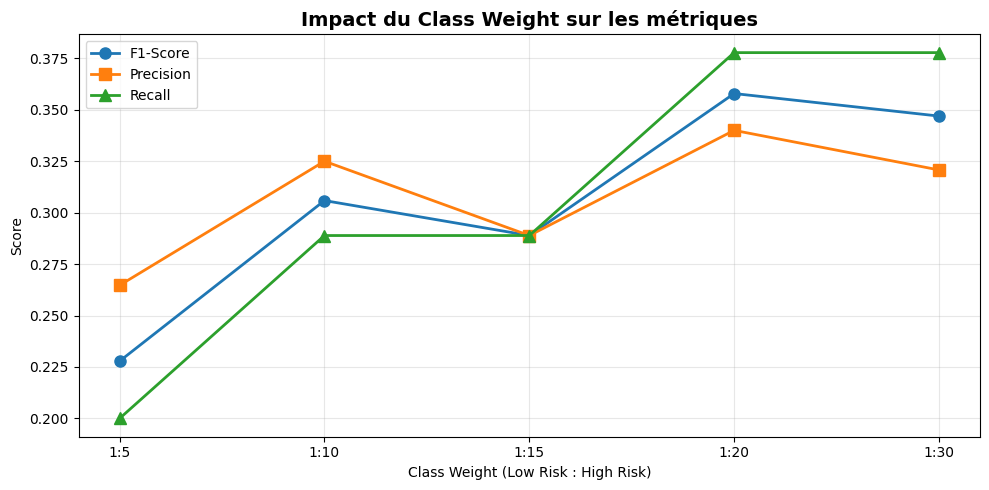

In [110]:
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(weights_df))
ax.plot(x, weights_df['f1'], 'o-', label='F1-Score', linewidth=2, markersize=8)
ax.plot(x, weights_df['precision'], 's-', label='Precision', linewidth=2, markersize=8)
ax.plot(x, weights_df['recall'], '^-', label='Recall', linewidth=2, markersize=8)
ax.set_xticks(x)
ax.set_xticklabels(weights_df['weight'])
ax.set_xlabel('Class Weight (Low Risk : High Risk)')
ax.set_ylabel('Score')
ax.set_title('Impact du Class Weight sur les métriques', fontsize=14, weight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [111]:
best_weight_idx = weights_df['f1'].idxmax()
print(f"\n Meilleur class_weight: {weights_df.loc[best_weight_idx, 'weight']}")
print(f"   F1-Score: {weights_df.loc[best_weight_idx, 'f1']:.4f}")



 Meilleur class_weight: 1:20
   F1-Score: 0.3579


XGBoost avec scale_pos_weight optimisé

In [112]:
scale_weights = [5, 10, 15, 20, 25, 30]
results_xgb_weights = []

for weight in scale_weights:
    xgb_weighted = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.05,
        scale_pos_weight=weight,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc'
    )
    xgb_weighted.fit(X_train, y_train)
    y_pred_xgb = xgb_weighted.predict(X_test)
    y_proba_xgb = xgb_weighted.predict_proba(X_test)[:, 1]

    results_xgb_weights.append({
        'scale_pos_weight': weight,
        'f1': f1_score(y_test, y_pred_xgb),
        'precision': precision_score(y_test, y_pred_xgb),
        'recall': recall_score(y_test, y_pred_xgb),
        'roc_auc': roc_auc_score(y_test, y_proba_xgb)
    })


In [113]:
xgb_weights_df = pd.DataFrame(results_xgb_weights)
print("\n XGBoost - Impact du scale_pos_weight:")
print(xgb_weights_df.round(4).to_string(index=False))



 XGBoost - Impact du scale_pos_weight:
 scale_pos_weight     f1  precision  recall  roc_auc
                5 0.2105     0.2581  0.1778   0.6341
               10 0.2439     0.2703  0.2222   0.6323
               15 0.3448     0.3571  0.3333   0.6458
               20 0.2921     0.2955  0.2889   0.6483
               25 0.3579     0.3400  0.3778   0.6462
               30 0.3596     0.3636  0.3556   0.6362


In [114]:
final_comparison = []

final_comparison.append({
    'Méthode': 'LightGBM Baseline (seuil=0.5)',
    'F1-Score': f1_score(y_test, (y_proba >= 0.5).astype(int)),
    'Precision': precision_score(y_test, (y_proba >= 0.5).astype(int)),
    'Recall': recall_score(y_test, (y_proba >= 0.5).astype(int)),
    'ROC-AUC': roc_auc_score(y_test, y_proba)
})

Seuil optimisé

In [115]:
final_comparison.append({
    'Méthode': f'LightGBM + Seuil optimal ({optimal_threshold:.2f})',
    'F1-Score': f1_score(y_test, y_pred_optimal),
    'Precision': precision_score(y_test, y_pred_optimal),
    'Recall': recall_score(y_test, y_pred_optimal),
    'ROC-AUC': roc_auc_score(y_test, y_proba)
})

SMOTE

In [116]:
final_comparison.append({
    'Méthode': 'LightGBM + SMOTE',
    'F1-Score': f1_score(y_test, y_pred_smote),
    'Precision': precision_score(y_test, y_pred_smote),
    'Recall': recall_score(y_test, y_pred_smote),
    'ROC-AUC': roc_auc_score(y_test, y_proba_smote)
})

SMOTE + Seuil optimal

In [117]:
final_comparison.append({
    'Méthode': f'LightGBM + SMOTE + Seuil ({optimal_smote_threshold:.2f})',
    'F1-Score': f1_score(y_test, y_pred_smote_optimal),
    'Precision': precision_score(y_test, y_pred_smote_optimal),
    'Recall': recall_score(y_test, y_pred_smote_optimal),
    'ROC-AUC': roc_auc_score(y_test, y_proba_smote)
})

 Meilleur class_weight

In [118]:
best_w = weights_df.loc[weights_df['f1'].idxmax()]
final_comparison.append({
    'Méthode': f'LightGBM + class_weight {best_w["weight"]}',
    'F1-Score': best_w['f1'],
    'Precision': best_w['precision'],
    'Recall': best_w['recall'],
    'ROC-AUC': best_w['roc_auc']
})

In [119]:
final_df = pd.DataFrame(final_comparison).sort_values('F1-Score', ascending=False)
print(final_df.round(4).to_string(index=False))

                        Méthode  F1-Score  Precision  Recall  ROC-AUC
LightGBM + Seuil optimal (0.08)    0.4052     0.2870  0.6889   0.6475
LightGBM + SMOTE + Seuil (0.05)    0.3660     0.2593  0.6222   0.6074
   LightGBM + class_weight 1:20    0.3579     0.3400  0.3778   0.6132
  LightGBM Baseline (seuil=0.5)    0.2703     0.3448  0.2222   0.6475
               LightGBM + SMOTE    0.2703     0.3448  0.2222   0.6074


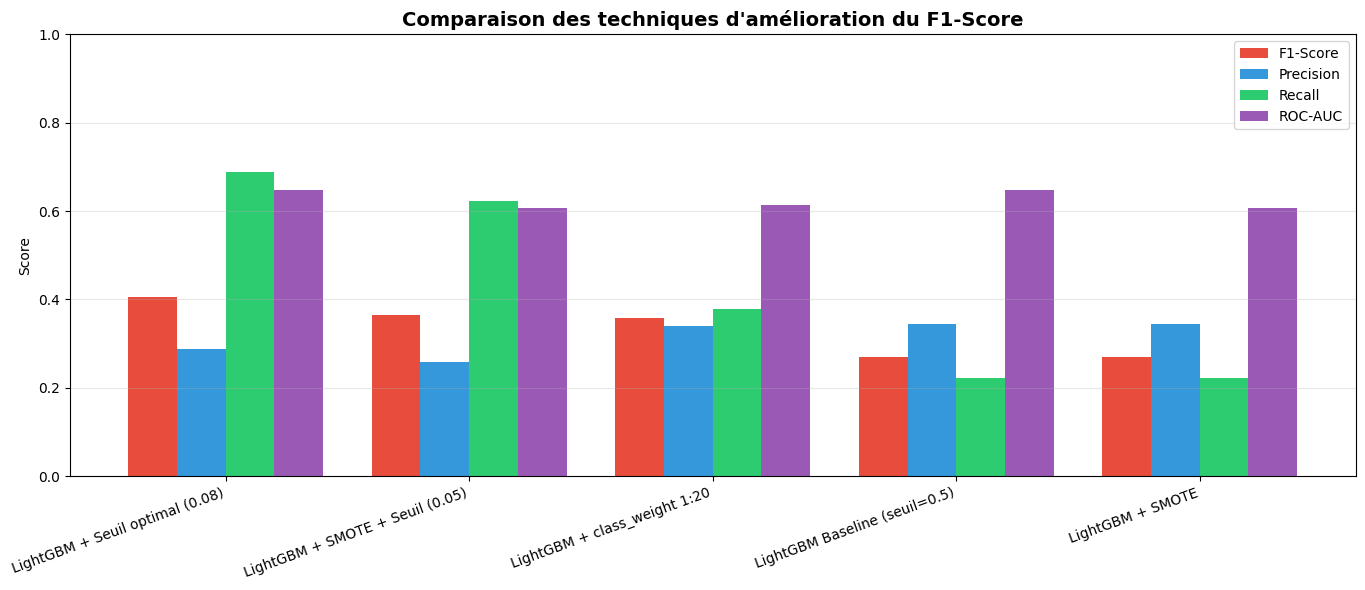

In [120]:
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(final_df))
width = 0.2

ax.bar(x - width*1.5, final_df['F1-Score'], width, label='F1-Score', color='#e74c3c')
ax.bar(x - width/2, final_df['Precision'], width, label='Precision', color='#3498db')
ax.bar(x + width/2, final_df['Recall'], width, label='Recall', color='#2ecc71')
ax.bar(x + width*1.5, final_df['ROC-AUC'], width, label='ROC-AUC', color='#9b59b6')

ax.set_ylabel('Score')
ax.set_title('Comparaison des techniques d\'amélioration du F1-Score', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(final_df['Méthode'], rotation=20, ha='right')
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [121]:
best_method = final_df.iloc[0]
print(f"\n MEILLEURE APPROCHE: {best_method['Méthode']}")
print(f"   F1-Score: {best_method['F1-Score']:.4f}")
print(f"   Precision: {best_method['Precision']:.4f}")
print(f"   Recall: {best_method['Recall']:.4f}")
print(f"   ROC-AUC: {best_method['ROC-AUC']:.4f}")


 MEILLEURE APPROCHE: LightGBM + Seuil optimal (0.08)
   F1-Score: 0.4052
   Precision: 0.2870
   Recall: 0.6889
   ROC-AUC: 0.6475


In [122]:
best_final_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=50,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

In [123]:
best_final_model.fit(X_train, y_train)


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=8,
               n_estimators=300, num_leaves=50, random_state=42, verbose=-1)

In [125]:
with open('best_model_lgbm.pkl', 'wb') as f:
    pickle.dump(best_final_model, f)
print(" Modèle sauvegardé: best_model_lgbm.pkl")


 Modèle sauvegardé: best_model_lgbm.pkl


In [126]:
model_config = {
    'model_name': 'LightGBM',
    'optimal_threshold': 0.08,  # Ton seuil optimal
    'features': list(X_train.columns),
    'metrics': {
        'f1_score': 0.4052,
        'precision': 0.2870,
        'recall': 0.6889,
        'roc_auc': 0.6475
    },
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')
}

In [127]:
with open('model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)
print(" Configuration sauvegardée: model_config.pkl")


 Configuration sauvegardée: model_config.pkl


In [128]:
X_test.to_csv('X_test_monitoring.csv', index=False)
pd.Series(y_test).to_csv('y_test_monitoring.csv', index=False)
pd.Series(y_proba).to_csv('y_proba_test.csv', index=False)
print(" Données de test sauvegardées pour le monitoring")


 Données de test sauvegardées pour le monitoring
